In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute
from matplotlib import pyplot
from tsfresh import extract_features
import xgboost as xgb
from sklearn.metrics import accuracy_score

plt.style.use('seaborn')
import seaborn as sns

from tqdm import tqdm

In [2]:
time_series = pd.read_csv('commit_data_500.csv', header=None, names = ["Date", "Y"])
time_series = time_series.set_index("Date")
time_series.head()

,Y
Date,
2018-12-17 13:00:00,4
2018-12-17 14:00:00,0
2018-12-17 15:00:00,1
2018-12-17 16:00:00,0
2018-12-17 17:00:00,0


In [3]:
import tsfresh
df_shift, y = make_forecasting_frame(time_series["Y"], kind="number", max_timeshift=20, rolling_direction=1)
df_shift.head()

/miniconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)


,time,value,id,kind
15865,2018-12-17 13:00:00,4.0,2018-12-17 14:00:00,number
15021,2018-12-17 13:00:00,4.0,2018-12-17 15:00:00,number
15866,2018-12-17 14:00:00,0.0,2018-12-17 15:00:00,number
14178,2018-12-17 13:00:00,4.0,2018-12-17 16:00:00,number
15022,2018-12-17 14:00:00,0.0,2018-12-17 16:00:00,number


In [4]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)
X["feature_last_value"] = y.shift(1)
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [ ]:
X.head()

In [ ]:
model = xgb.XGBClassifier()
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):

    model.fit(X.iloc[:i], y[:i])
    y_pred[i] = model.predict(X.iloc[i:])
    
y_pred = pd.Series(data=y_pred, index=y.index)

 47%|████▋     | 352/744 [1:16:57<2:31:11, 23.14s/it]

In [15]:
model = xgb.XGBClassifier()
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# задаём параметры
params = {
    'objective': 'reg:linear',
    'booster':'gblinear'
}
trees = 1000

# прогоняем на кросс-валидации с метрикой rmse
cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].idxmin())


deviation = cv.loc[cv['test-rmse-mean'].idxmin()]["test-rmse-mean"]

#for i in tqdm(range(isp, len(y))):
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

#predictions = [round(value) for value in y_pred]

#accuracy = accuracy_score(y_test, predictions)
#print(accuracy)
    
#y_pred = pd.Series(data=y_pred, index=y.index)

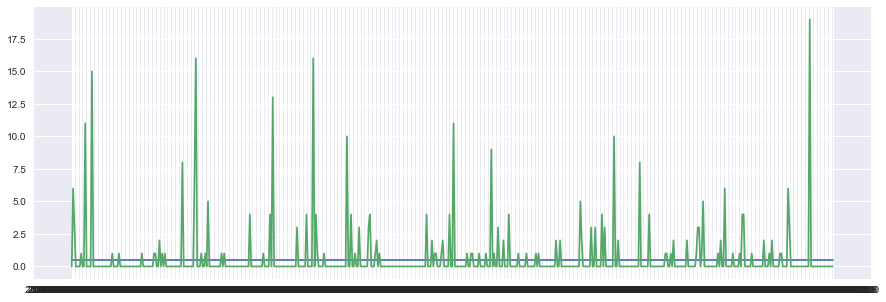

In [22]:
prediction_train = bst.predict(dtrain)
plt.figure(figsize=(15, 5))
plt.plot(prediction_train)
plt.plot(y_train)
plt.axis('tight')
plt.grid(True)

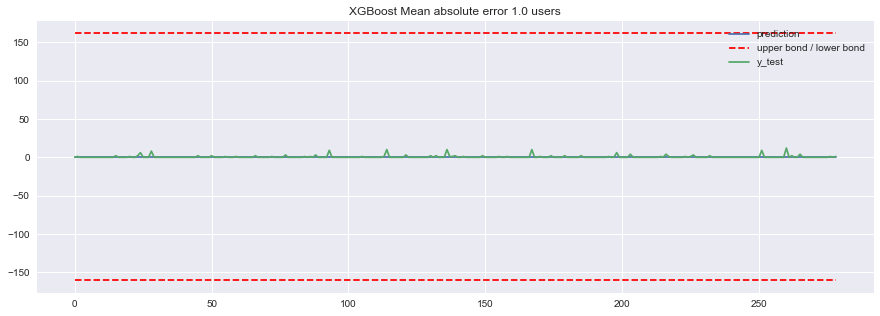

In [24]:
 scale=1.96

prediction_test = bst.predict(dtest)
lower = prediction_test-scale*deviation
upper = prediction_test+scale*deviation

Anomalies = np.array([np.NaN]*len(y_test))
Anomalies[y_test<lower] = y_test[y_test<lower]

plt.figure(figsize=(15, 5))
plt.plot(prediction_test, label="prediction")
plt.plot(lower, "r--", label="upper bond / lower bond")
plt.plot(upper, "r--")
plt.plot(list(y_test), label="y_test")
plt.plot(Anomalies, "ro", markersize=10)
plt.legend(loc="best")
plt.axis('tight')
plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
plt.grid(True)
plt.legend()

In [ ]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [7]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

,pred,true
Date,,
2018-11-24 15:00:00,NaN,0
2018-11-24 16:00:00,NaN,0
2018-11-24 17:00:00,NaN,0
2018-11-24 18:00:00,NaN,0
2018-11-24 19:00:00,NaN,0


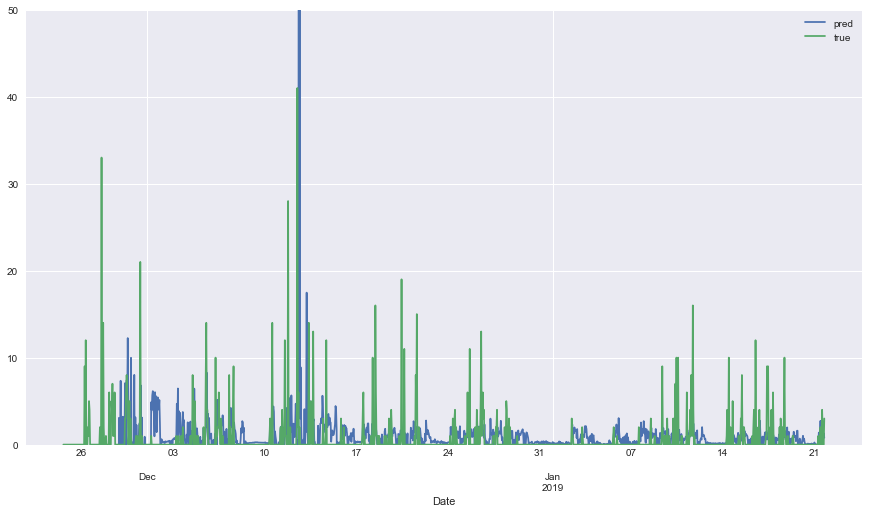

In [12]:
ys.plot(figsize=(15, 8)).set_ylim(0,50)
#plt.show()
savefig("plot500XGBoost.png")

In [16]:
print("MAE ada: \t{}".format(mean_absolute_error(y[isp:], y_pred[isp:])))
print("MSE ada: \t{}".format(mean_squared_error(y[isp:], y_pred[isp:])))

count = 0
truePred = 0
for idx, val in y_pred.iteritems():
    count += 1
    if val < 1 and y[idx] < 1:
        truePred += 1

print("Update metric: \t{}%".format(truePred/count*100))

count = 0
truePred = 0
for idx, val in y_pred.iteritems():
    count += 1
    if abs(val - y[idx]) <= 1:
        truePred += 1

print("Delta metric: \t{}%".format(truePred/count*100))

MAE ada: 	9.29949501658513
MSE ada: 	56981.86155908134
Update metric: 	50.931232091690546%
Delta metric: 	54.44126074498568%
